<a href="https://colab.research.google.com/github/PaulPhSpr/Seminararbeit/blob/master/code/PiCar/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Das Notebook zum Training des DeepPiCar**

Teil 3 und 4 sind adaptiert aus: Tian, David (2019). DeepPiCar - Part 5. Zuletzt abgerufen am 27.05.2020. Verfügbar unter: https://towardsdatascience.com/deeppicar-part-5-lane-following-via-deep-learning-d93acdce6110

# Teil 1 - Import der Bibliotheken

In [2]:
#--Standart-Bibliotheken--#
import os #zum Arbeiten mit Dateipfaden
import random 
import numpy as np

#--Machine Learning--#
import keras #High Lever Schnittstelle für Tensorflow
from keras.models import Model #zum Zusammenbauen
from keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense #verschiedene Layer
from keras.optimizers import SGD #Stochastic Gradient Descent
from keras.models import load_model #für das Laden
from keras.preprocessing.image import ImageDataGenerator

#--Vorbereitung ML--#
from sklearn.model_selection import train_test_split #um den Datensatz aufzuteilen

#--Graphik--#
import cv2
from imgaug import augmenters as img_aug #Data Augmentation
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline 
from PIL import ImageFilter, Image #um Bilder zu bearbeiten und anzuzeigen

#--Auswertung--#
!pip3 install deeplearning2020
from deeplearning2020 import helpers #(OpenHPI, 2020)

Using TensorFlow backend.


     |████████████████████████████████| 399kB 4.8MB/s 
  Created wheel for deeplearning2020: filename=deeplearning2020-0.4.21-py2.py3-none-any.whl size=8548 sha256=6503d7c6fc64649fa2eb35d317b58c4e0979dd575a6e8c4397e53fa660ab28e3
  Stored in directory: /root/.cache/pip/wheels/7f/c2/8a/f9f03fc839999f1fe9d5e5a9d2c97cdd5cb8329f61f82ea2c9
  Created wheel for kerasltisubmission: filename=kerasltisubmission-0.4.9-py2.py3-none-any.whl size=8867 sha256=66a767313d90d58648de9ab76476cb1354db5fa4e4fb2f267a397bb896572e68
  Stored in directory: /root/.cache/pip/wheels/fd/61/f7/09171376b25408ae21b58e98c9fbf2eb924f676bb77659f983
Successfully built deeplearning2020 kerasltisubmission


# Teil 2 - Download der Daten

In [3]:
#--Daten aus GitHub herunterladen--#
!cd /content
!git clone https://github.com/PaulPhSpr/Seminararbeit 

Cloning into 'Seminararbeit'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 2325 (delta 8), reused 38 (delta 1), pack-reused 2279
Receiving objects: 100% (2325/2325), 43.88 MiB | 35.89 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [0]:
#--Speicherorte angeben--#
bas_dir = "Seminararbeit/Datensatz"
train_dir = os.path.join(bas_dir, "train")
valid_dir = os.path.join(bas_dir, "valid")

#--Anzahl der Klassen --#
num_of_classes = 19

# Teil 3 - Data Augmentation

In [0]:
#--Zoom--#
def zoom(bild):
  zoom = img_aug.Affine(scale=(1, 1.3)) #zufälliger zoom zwischen 100% und 130%
  bild = zoom.augment_image(bild)
  return bild

#--Rotation um 180°--#
def flip(bild, steuerwinkel):
  flipJa = random.randint(0,1)
  if flipJa == 1:
    bild = cv2.flip(bild, 1)
    steuerwinkel = num_of_classes - 1 - steuerwinkel
  return bild, steuerwinkel

#--Unschärfe--#
def blur(bild):
  kernel = random.randint(1,5) #alles darüber zu verschwommen
  bild = cv2.blur(bild, (kernel, kernel))
  return bild

def hell(bild):
  helligkeit = img_aug.Multiply((0.7, 1.3)) #70%-130%
  bild = helligkeit.augment_image(bild)
  return bild

#--Zusammenbringen--#
def augmentation(bild, steuerwinkel):
  if np.random.rand() < 0.5:
    bild = zoom(bild)
  if np.random.rand() < 0.5:
    bild = blur(bild)
  if np.random.rand() < 0.5:
    bild = hell(bild)
  if np.random.rand() < 0.5:
    bild, steuerwinkel = flip(bild, steuerwinkel)
  return bild, steuerwinkel

# Teil 4 - Daten vorbereiten für Training

In [0]:
#--Aus Array von Arrays ein Array aus Bildern--#
def toBild(bild):
  bild = Image.fromarray((bild).astype(np.uint8)) #nur dieses Dateiformat wird von Pillow akzeptiert
  bild = cv2.cvtColor(np.array(bild), cv2.COLOR_BGR2RGB) #in numpy bild umwandeln
  return bild

#--Bilder standardisieren--#
def vorbereitung_bild(bild):
  bild = toBild(bild)
  return bild

#--Aus Categorical zu Numeric, [0, 0, 1, 0] --> 3
def vorbereitung_steuerwinkel(winkel):
  for i in range(num_of_classes):
    if winkel[i] != 0:
      return i

#--Bildgenerator für Trainingsprozess--#
def bild_dat_generator(bilder, steuerwinkel, trainiert):
  batch_bild = []
  batch_steuerwinkel = []

  #so viele Bilder wie angeben ausgeben
  for i in range(len(bilder)):
    rand_i = random.randint(0, len(bilder)) #ein Bild aussuchen

    #bild nehmen
    bild = bilder[rand_i]
    bild = vorbereitung_bild(bild)

    #steuerwinkel nehmen
    str_winkel = steuerwinkel[rand_i]
    str_winkel = vorbereitung_steuerwinkel(str_winkel) 

    #Augmentation
    if(trainiert):
      bild, str_winkel = augmentation(bild, str_winkel)

    bild = cv2.cvtColor(bild, cv2.COLOR_BGR2RGB)
    #Abspeichern
    batch_bild.append(bild)
    batch_steuerwinkel.append(str_winkel)

  return np.asarray(batch_bild), np.asarray(batch_steuerwinkel)

In [12]:
#--Batches--#
classes = ["class" + str(i) for i in range(1, num_of_classes + 1)]
train_batches = ImageDataGenerator().flow_from_directory(train_dir, target_size = (108, 146), classes=classes, batch_size = 1723) 
valid_batches = ImageDataGenerator().flow_from_directory(valid_dir, target_size = (108, 146), classes=classes, batch_size = 431)

Found 1723 images belonging to 19 classes.
Found 431 images belonging to 19 classes.


In [0]:
#--Trainingsdaten zusammenführen--#
#Trainingsdaten
bilder, label = next(train_batches)
X_train, y_train = bild_dat_generator(bilder, label, True)
#Validierungsdaten
bilder, label = next(valid_batches)
valid_data = bild_dat_generator(bilder, label, False)

# Teil 5 - Baue Modell

In [23]:
def baue_model():
  #--Params--#
  lr = 0.0001 #Learning Rate
  momentum = 0.9 #Parameter für SGD, entspricht Trägheit beim Abstieg
  dense_neurons = 2000

  activation = "elu" #Aktivierungsfunktion

  input_layer = Input(shape=(108, 146, 3)) #146x108px, 3 Farbkanäle

  #--Convultional Layers--#
  model = Conv2D(filters = 320, kernel_size = (5, 5), activation = activation, padding="same") (input_layer)
  model = MaxPooling2D((2,2)) (model)
  model = Conv2D(filters = 394, kernel_size = (5, 5), activation = activation, padding="same") (model)
  model = MaxPooling2D((2,2)) (model)
  model = Conv2D(filters = 458, kernel_size = (5, 5), activation = activation, padding="same") (model)
  model = MaxPooling2D((2,2)) (model)
  model = Conv2D(filters = 522, kernel_size = (3, 3), activation = activation, padding="same") (model)
  model = MaxPooling2D((2,2)) (model)
  model = Conv2D(filters = 586, kernel_size = (3, 3), activation = activation, padding="same") (model)
  model = MaxPooling2D((2,2)) (model)
  model = Conv2D(filters = 650, kernel_size = (3, 3), activation = activation, padding="same") (model)
  model = MaxPooling2D((2,2)) (model)

  #--Dense Layers--#
  model = Flatten() (model)
  model = Dense(dense_neurons, activation=activation) (model)
  model = Dense(dense_neurons // 2, activation="tanh") (model)

  #--Output--#
  out = Dense(num_of_classes, activation = "softmax") (model)
  CNN_model = Model(input_layer, out)

  #--Wie lernen?--#
  optimizer = SGD(lr=lr, momentum=momentum)

  #--Kompilieren und Ausgeben--#
  CNN_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

  return CNN_model

model = baue_model()
print(model.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 108, 146, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 108, 146, 320)     24320     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 54, 73, 320)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 54, 73, 394)       3152394   
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 27, 36, 394)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 27, 36, 458)       4511758   
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 13, 18, 458)       0   

# Teil 6 - Das Modell trainieren

Train on 1723 samples, validate on 431 samples
Epoch 1/15
1723/1723 [==============================] - 33s 19ms/step - loss: 2.0700 - accuracy: 0.2931 - val_loss: 1.7044 - val_accuracy: 0.4942
Epoch 2/15
1723/1723 [==============================] - 32s 19ms/step - loss: 1.6616 - accuracy: 0.4231 - val_loss: 1.4615 - val_accuracy: 0.5406
Epoch 3/15
1723/1723 [==============================] - 32s 19ms/step - loss: 1.5266 - accuracy: 0.4852 - val_loss: 1.2970 - val_accuracy: 0.5847
Epoch 4/15
1723/1723 [==============================] - 32s 19ms/step - loss: 1.4125 - accuracy: 0.5113 - val_loss: 1.3525 - val_accuracy: 0.5754
Epoch 5/15
1723/1723 [==============================] - 32s 19ms/step - loss: 1.3438 - accuracy: 0.5421 - val_loss: 1.3327 - val_accuracy: 0.5290
Epoch 6/15
1723/1723 [==============================] - 32s 19ms/step - loss: 1.2437 - accuracy: 0.5844 - val_loss: 1.0668 - val_accuracy: 0.6566
Epoch 7/15
1723/1723 [==============================] - 32s 19ms/step - loss:

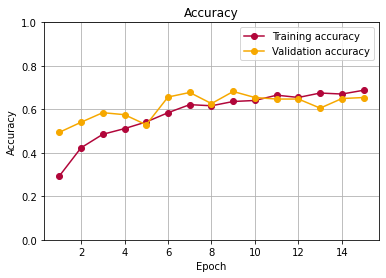

In [24]:
#--Training--#
history = model.fit(
    X_train, y_train, #Trainingsdaten generieren
    validation_data = valid_data, #Validierungsdaten generieren
    epochs = 15, #anzahl durchgänge
)

#--Trainings und Validierungsgenauigkeit anzeigen--#
helpers.plot_history("Accuracy", history, 0)

# Teil 7 - Evaluieren

In [0]:
model.save("DeepPiCar.h5")

In [0]:
#--kategorisch in numerisch umwandeln--#
def auswertung_steuerwinkel(y):
  max = 0
  for i in range(len(y)):
    if(y[i] > y[max]):
      max = i
  return max 

#--Vorhersagen--#
def vorhersage(X):
  model = load_model('DeepPiCar.h5')
  y_pred = model.predict(X)
  return y_pred

In [36]:
#--Testdaten generieren--#4
bs = 50
test_batches = ImageDataGenerator().flow_from_directory(valid_dir, target_size = (108, 146), classes=classes, batch_size = bs)
X_test, y_test = next(test_batches)
y_pred = vorhersage(X_test)

Found 431 images belonging to 19 classes.


Gemessener Winkel = 120, Vorhergesagter Winkel = 120


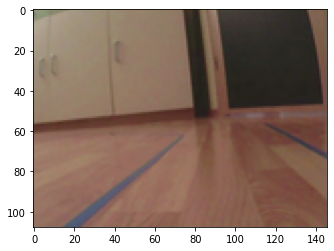

In [46]:
#--Anzeigen--#
num = random.randint(0, bs - 1)
gemessener_winkel = (vorbereitung_steuerwinkel(y_test[num]) + 1)* 10
ausgewerteter_winkel = auswertung_steuerwinkel(y_pred[num]) * 10
print(f"Gemessener Winkel = {gemessener_winkel}, Vorhergesagter Winkel = {ausgewerteter_winkel}")
plt.imshow(X_test[num] / 255) #damit werte von 0 bis eins sind